# Problem Statement

Ecommerce is expected to grow above 5 trillion in 2022 and is expected to continue growing exponentially due to the popularity of online shopping. According to a study by Business Wire in 2019, more than 70% of consumers surveyed considered product reviews to be important. As it is difficult for a human to read every single review, we aim to classify customer comments to allow comments to be helpful to the organisation. When organisations understand their customers, this can help companies take actionable steps to help boost their business, brand and value.



In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import sklearn
import string
import re
import scikitplot as skplt
import plotly.graph_objs as go
import seaborn as sns
import pickle


from plotly.subplots import make_subplots
from plotly.offline import iplot

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag

from sklearn import preprocessing 

from matplotlib import rcParams



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score

from wordcloud import WordCloud
from wordcloud import STOPWORDS

from collections import defaultdict
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline




# Load Dataset

Dataset loaded in a small sample taken from the Kaggle Dataset:  Amazon Product Review

https://www.kaggle.com/naveedhn/amazon-product-review-spam-and-non-spam/metadata

In [2]:
data = pd.read_json(r"C:\Users\wayne\Desktop\Cell_Phones_and_Accessories.json",lines=True)

# Data Preprocessing

We will start by checking for null values

In [3]:
data.head()

_id      reviewerID        asin  \
0  {'$oid': '5a1321d5741a2384e802c552'}   A3HVRXV0LVJN7  0110400550   
1  {'$oid': '5a1321d5741a2384e802c557'}  A1BJGDS0L1IO6I  0110400550   
2  {'$oid': '5a1321d5741a2384e802c550'}   A1YX2RBMS1L9L  0110400550   
3  {'$oid': '5a1321d5741a2384e802c553'}  A180NNPPKWCCU0  0110400550   
4  {'$oid': '5a1321d5741a2384e802c559'}  A30P2CYOUYAJM8  0110400550   

       reviewerName helpful  \
0      BiancaNicole  [4, 4]   
1            cf "t"  [0, 3]   
2      Andrea Busch  [0, 0]   
3  Aniya pennington  [3, 3]   
4              Gene  [1, 1]   

                                          reviewText  overall  \
0  Best phone case ever . Everywhere I go I get a...        5   
1  ITEM NOT SENT from Blue Top Company in Hong Ko...        1   
2  Saw this same case at a theme park store for 2...        5   
3  case fits perfectly and I always gets complime...        5   
4  I got this for my 14 year old sister.  She lov...        4   

           summary  unixReviewTime   reviewTime                     category  \
0            A++++      1358035200  01 13, 2013  Cell_Phones_and_Accessories   
1  ITEM NOT SENT!!      1359504000  01 30, 2013  Cell_Phones_and_Accessories   
2    Great product      1353542400  11 22, 2012  Cell_Phones_and_Accessories   
3          Perfect      1374105600  07 18, 2013  Cell_Phones_and_Accessories   
4   Cool purchase.      1363737600  03 20, 2013  Cell_Phones_and_Accessories   

   class  
0      1  
1      0  
2      1  
3      1  
4      1

In [4]:
data.isna().sum()

_id                  0
reviewerID           0
asin                 0
reviewerName      2912
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
category             0
class                0
dtype: int64

We can see that there are 2912 null values. Null Reviewer Names will be imputed with "missing"

In [5]:
data.reviewerName.fillna("missing",inplace = True)

In [6]:
data.isna().sum()

_id               0
reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
category          0
class             0
dtype: int64

# Concat all text together
We will combine the text for summary and review text as meaning will not contridict and we will use it for our text classification later.

In [7]:
data["combinedText"] = data["reviewText"]+data["summary"]
data = data.drop(["reviewText","summary"], axis =1)

# Identifying Sentiment 

We will create 3 classes: 

Positive will consist rating 4-5

Neutral will consist rating 3

Negative will consist rating 1-2

In [8]:
data.groupby('overall').size()

overall
1     83164
2     39430
3     48484
4     98308
5    230614
dtype: int64

In [9]:
def rating_to_sentiment(rating):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if rating == 3:
        return 'Neutral'
    elif rating == 1 or rating == 2:
        return 'Negative'
    elif rating == 4 or rating == 5:
        return 'Positive'
    else :
        return "Error"

In [10]:
data["sentiment"] = data.overall.apply(rating_to_sentiment)
data = data.drop(["overall"], axis =1)

In [11]:
data.sentiment.value_counts()

Positive    328922
Negative    122594
Neutral      48484
Name: sentiment, dtype: int64

# Creating Year Month and Day 

In [12]:
datearray = data['reviewTime'].str.split(',',expand = True)

In [13]:
data['date']= datearray[0]
data['year']= datearray[1]

monthday = data['date'].str.split(' ',expand = True)
data['month'] = monthday[0]
data['day'] = monthday[1]

data = data.drop(["unixReviewTime","reviewTime","date"], axis =1)

In [14]:
data.head()

_id      reviewerID        asin  \
0  {'$oid': '5a1321d5741a2384e802c552'}   A3HVRXV0LVJN7  0110400550   
1  {'$oid': '5a1321d5741a2384e802c557'}  A1BJGDS0L1IO6I  0110400550   
2  {'$oid': '5a1321d5741a2384e802c550'}   A1YX2RBMS1L9L  0110400550   
3  {'$oid': '5a1321d5741a2384e802c553'}  A180NNPPKWCCU0  0110400550   
4  {'$oid': '5a1321d5741a2384e802c559'}  A30P2CYOUYAJM8  0110400550   

       reviewerName helpful                     category  class  \
0      BiancaNicole  [4, 4]  Cell_Phones_and_Accessories      1   
1            cf "t"  [0, 3]  Cell_Phones_and_Accessories      0   
2      Andrea Busch  [0, 0]  Cell_Phones_and_Accessories      1   
3  Aniya pennington  [3, 3]  Cell_Phones_and_Accessories      1   
4              Gene  [1, 1]  Cell_Phones_and_Accessories      1   

                                        combinedText sentiment   year month  \
0  Best phone case ever . Everywhere I go I get a...  Positive   2013    01   
1  ITEM NOT SENT from Blue Top Company in Hong Ko...  Negative   2013    01   
2  Saw this same case at a theme park store for 2...  Positive   2012    11   
3  case fits perfectly and I always gets complime...  Positive   2013    07   
4  I got this for my 14 year old sister.  She lov...  Positive   2013    03   

  day  
0  13  
1  30  
2  22  
3  18  
4  20

# Creating Helpfulness Rate 

Current rate is in [a,b] format which is not easily understood or useful for calculations, hence we will be converting it into a/b value. 

We will use a lamda to do a calculation in the helpful column for a/b for all rows

In [15]:
pd.set_option('display.max_rows', 100)
data['helpfulrate']=data['helpful'].apply(lambda x: 0 if x[1]==0 else x[0]/x[1])

In [16]:
data['helpfulrate'].value_counts()

0.000000    359027
1.000000     96942
0.500000     11546
0.666667      5390
0.750000      3460
             ...  
0.984375         1
0.019481         1
0.993031         1
0.914634         1
0.891473         1
Name: helpfulrate, Length: 1207, dtype: int64

0 indicates the review was not very helpful and 1 indicates that the review has been helpful

# Text cleaning

Make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers.

We will now make lowercase and remove punctuation

In [17]:
def text_cleaning(text):

    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [18]:
data["combinedText"] = data["combinedText"].apply(text_cleaning)

In [19]:
data.head()

_id      reviewerID        asin  \
0  {'$oid': '5a1321d5741a2384e802c552'}   A3HVRXV0LVJN7  0110400550   
1  {'$oid': '5a1321d5741a2384e802c557'}  A1BJGDS0L1IO6I  0110400550   
2  {'$oid': '5a1321d5741a2384e802c550'}   A1YX2RBMS1L9L  0110400550   
3  {'$oid': '5a1321d5741a2384e802c553'}  A180NNPPKWCCU0  0110400550   
4  {'$oid': '5a1321d5741a2384e802c559'}  A30P2CYOUYAJM8  0110400550   

       reviewerName helpful                     category  class  \
0      BiancaNicole  [4, 4]  Cell_Phones_and_Accessories      1   
1            cf "t"  [0, 3]  Cell_Phones_and_Accessories      0   
2      Andrea Busch  [0, 0]  Cell_Phones_and_Accessories      1   
3  Aniya pennington  [3, 3]  Cell_Phones_and_Accessories      1   
4              Gene  [1, 1]  Cell_Phones_and_Accessories      1   

                                        combinedText sentiment   year month  \
0  best phone case ever  everywhere i go i get a ...  Positive   2013    01   
1  item not sent from blue top company in hong ko...  Negative   2013    01   
2  saw this same case at a theme park store for  ...  Positive   2012    11   
3  case fits perfectly and i always gets complime...  Positive   2013    07   
4  i got this for my  year old sister  she loves ...  Positive   2013    03   

  day  helpfulrate  
0  13          1.0  
1  30          0.0  
2  22          0.0  
3  18          1.0  
4  20          1.0

# Curating my own stopwords

We have identified several words in the default stop words list which may be useful in identifying negative sentiment, hence words from the default list has been removed.

In [20]:
stop = set(stopwords.words('english'))
print(stop)

{'doing', 'from', 'further', 'are', 'until', 'them', 've', 'shan', 'won', 'o', 'than', 'at', 'when', 'will', 'how', 'weren', 'if', "hadn't", 'other', 'yourselves', 'off', 'very', 'each', 'most', 'herself', 'ourselves', 'for', 'her', 'there', 'am', 'by', 'yourself', "should've", "couldn't", 'these', 'between', 'just', 'should', "wouldn't", 's', 'has', 'a', 'too', 'our', 'while', 'you', 't', 'during', 'm', 'doesn', 'same', "shouldn't", 'but', 'with', 'after', "won't", "aren't", 'over', 'hasn', 'through', "weren't", 'some', "don't", 'he', 'haven', 'as', "didn't", 'theirs', 'ours', 'this', 'in', 'we', "wasn't", 'having', 'here', 'the', 'd', 'yours', 'out', "hasn't", 'own', "you'd", 'because', 'shouldn', 'being', "you'll", 'don', 'y', "shan't", 'll', 'they', 'aren', 'wasn', "it's", 'about', 'more', 'both', 're', 'now', 'hadn', 'that', 'couldn', 'isn', 'was', 'mustn', 'needn', 'mightn', 'above', 'few', 'does', "doesn't", 'not', 'can', "mustn't", 'do', 'against', 'again', 'itself', "haven't",

In [21]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [22]:
def remove_stop_words(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stop_words:
            final_text.append(i.strip())
    return " ".join(final_text)

Remove Stopwords from combined text

In [23]:
data["combinedText"]= data["combinedText"].apply(remove_stop_words)

In [24]:
data.head()

_id      reviewerID        asin  \
0  {'$oid': '5a1321d5741a2384e802c552'}   A3HVRXV0LVJN7  0110400550   
1  {'$oid': '5a1321d5741a2384e802c557'}  A1BJGDS0L1IO6I  0110400550   
2  {'$oid': '5a1321d5741a2384e802c550'}   A1YX2RBMS1L9L  0110400550   
3  {'$oid': '5a1321d5741a2384e802c553'}  A180NNPPKWCCU0  0110400550   
4  {'$oid': '5a1321d5741a2384e802c559'}  A30P2CYOUYAJM8  0110400550   

       reviewerName helpful                     category  class  \
0      BiancaNicole  [4, 4]  Cell_Phones_and_Accessories      1   
1            cf "t"  [0, 3]  Cell_Phones_and_Accessories      0   
2      Andrea Busch  [0, 0]  Cell_Phones_and_Accessories      1   
3  Aniya pennington  [3, 3]  Cell_Phones_and_Accessories      1   
4              Gene  [1, 1]  Cell_Phones_and_Accessories      1   

                                        combinedText sentiment   year month  \
0  best phone case ever everywhere go get ton com...  Positive   2013    01   
1  item not sent blue top company hong kong two m...  Negative   2013    01   
2  saw case theme park store dollars good quality...  Positive   2012    11   
3  case fits perfectly always gets compliments ha...  Positive   2013    07   
4  got year old sister loves really really dont c...  Positive   2013    03   

  day  helpfulrate  
0  13          1.0  
1  30          0.0  
2  22          0.0  
3  18          1.0  
4  20          1.0

# Data Storytelling and Visualisation

# Helpful Rate visualisation

In [25]:
pd.DataFrame(data.groupby('sentiment')['helpfulrate'].mean())


helpfulrate
sentiment             
Negative      0.270432
Neutral       0.240727
Positive      0.242194

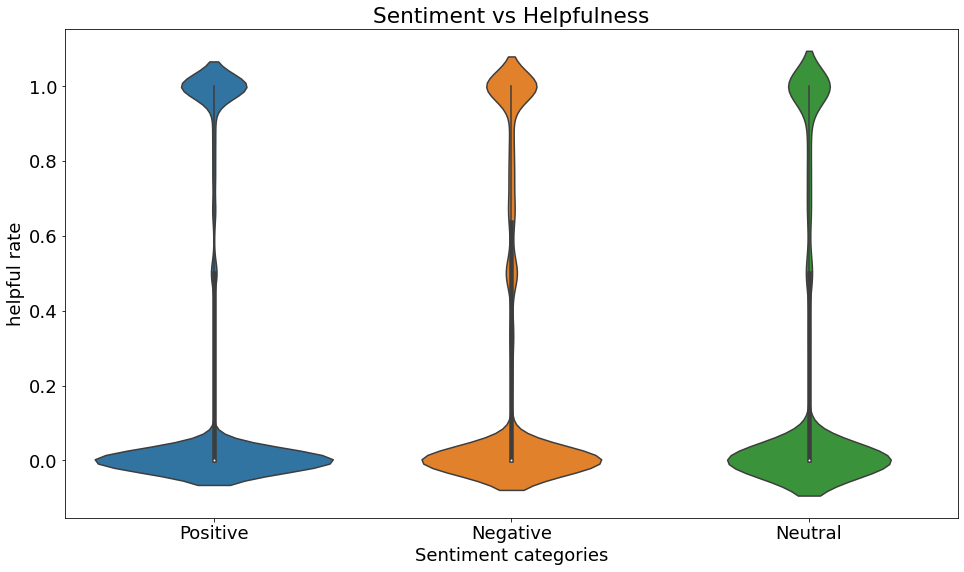

In [26]:
#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(data, columns = ['sentiment', 'helpful_rate'])
senti_help = senti_help[senti_help['helpful_rate'] != 0.00] 

#Plotting phase
sns.violinplot( x=data["sentiment"], y=data["helpfulrate"])
plt.title('Sentiment vs Helpfulness')
plt.xlabel('Sentiment categories')
plt.ylabel('helpful rate')
plt.show()

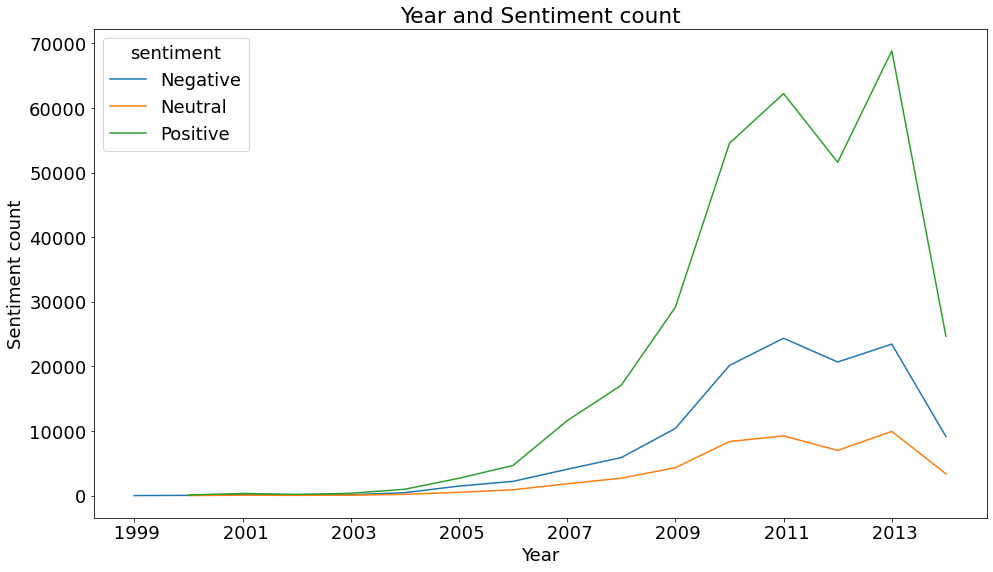

In [27]:
data.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

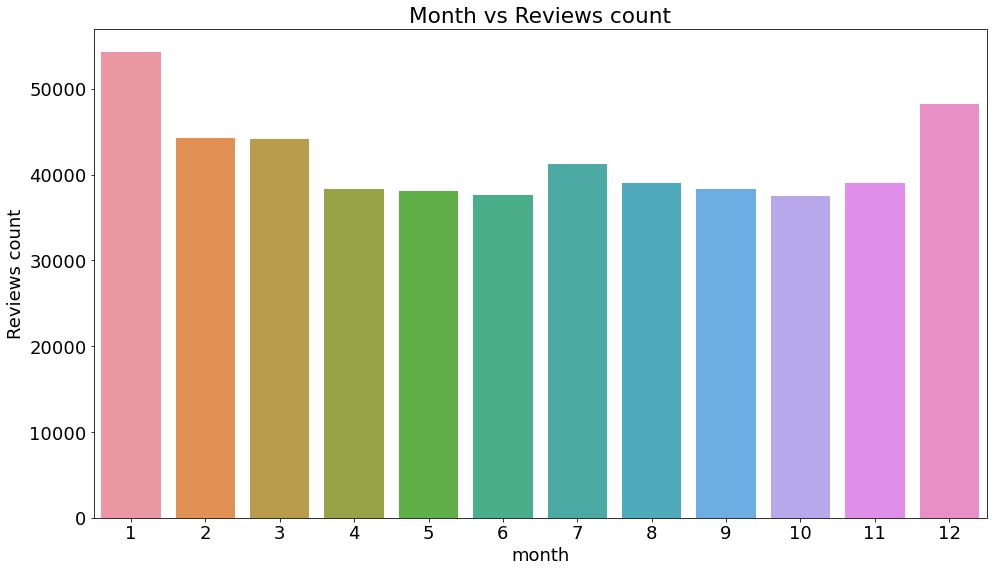

In [28]:
#Creating a dataframe
month=pd.DataFrame(data.groupby('month')['combinedText'].count()).reset_index()
month['month']=month['month'].astype('int64')
month.sort_values(by=['month'])

#Plotting the graph
sns.barplot(x="month", y="combinedText", data=month)
plt.title('Month vs Reviews count')
plt.xlabel('month')
plt.ylabel('Reviews count')
plt.show()

# Ngram visualisation

In [29]:
#Filtering data
review_positive = data[data["sentiment"]=='Positive']
review_neutral = data[data["sentiment"]=='Neutral']
review_negative = data[data["sentiment"]=='Negative']

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ")]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [30]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_positive["combinedText"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neutral["combinedText"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_negative["combinedText"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

In [31]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_positive["combinedText"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neutral["combinedText"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_negative["combinedText"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

In [32]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_positive["combinedText"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neutral["combinedText"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_negative["combinedText"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

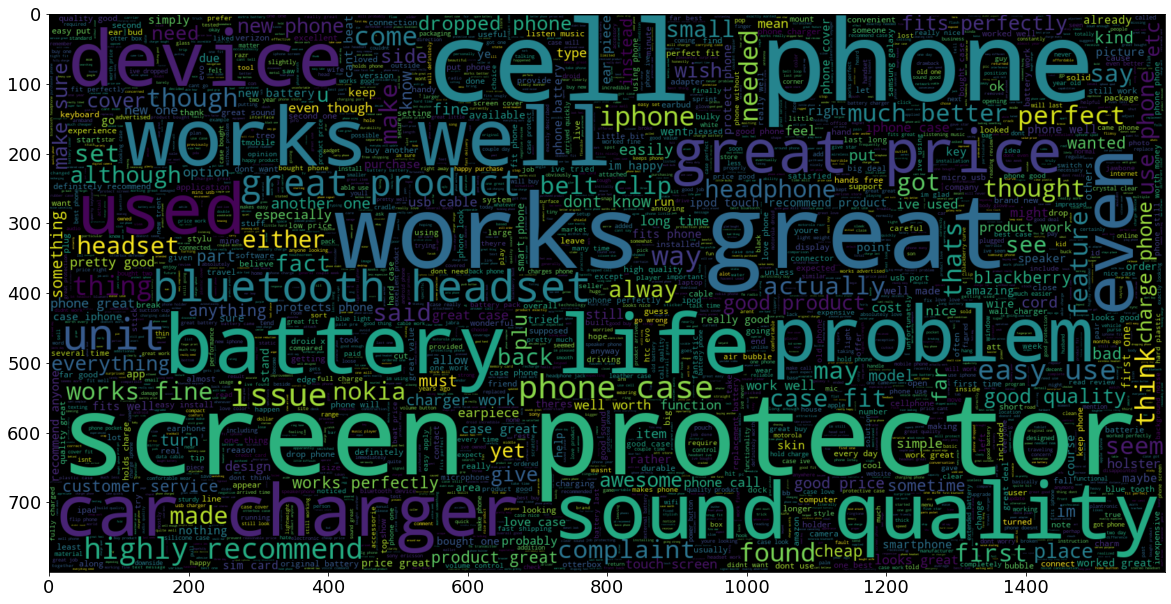

In [99]:
plt.figure(figsize = (20,20))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800).generate(" ".join(review_positive["combinedText"]))
plt.imshow(wc,interpolation = 'bilinear')

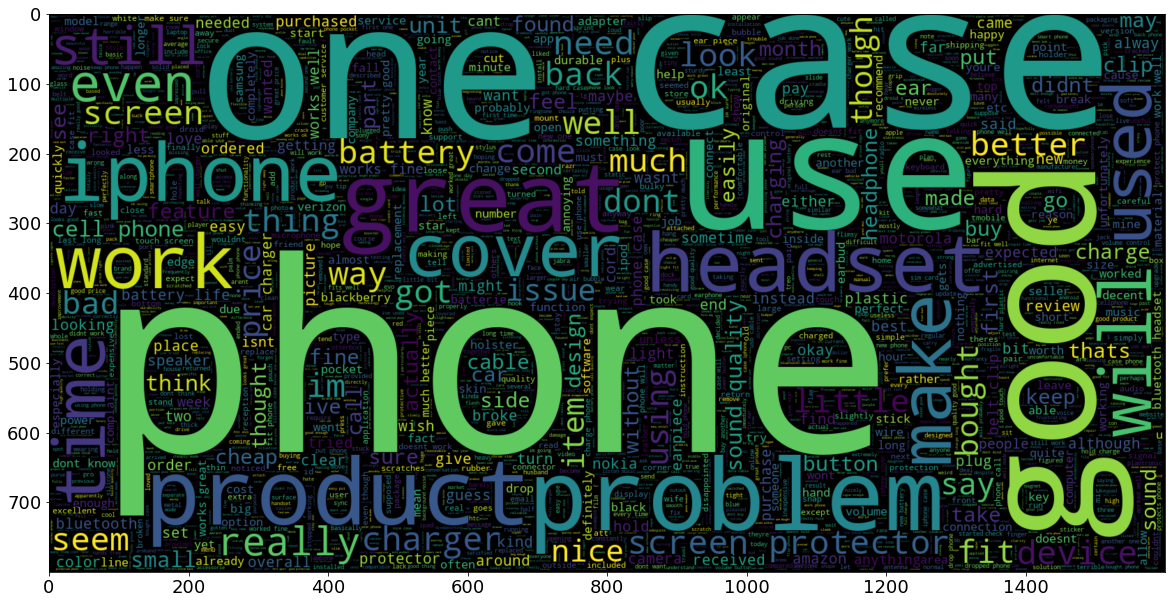

In [100]:
plt.figure(figsize = (20,20))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800).generate(" ".join(review_neutral["combinedText"]))
plt.imshow(wc,interpolation = 'bilinear')

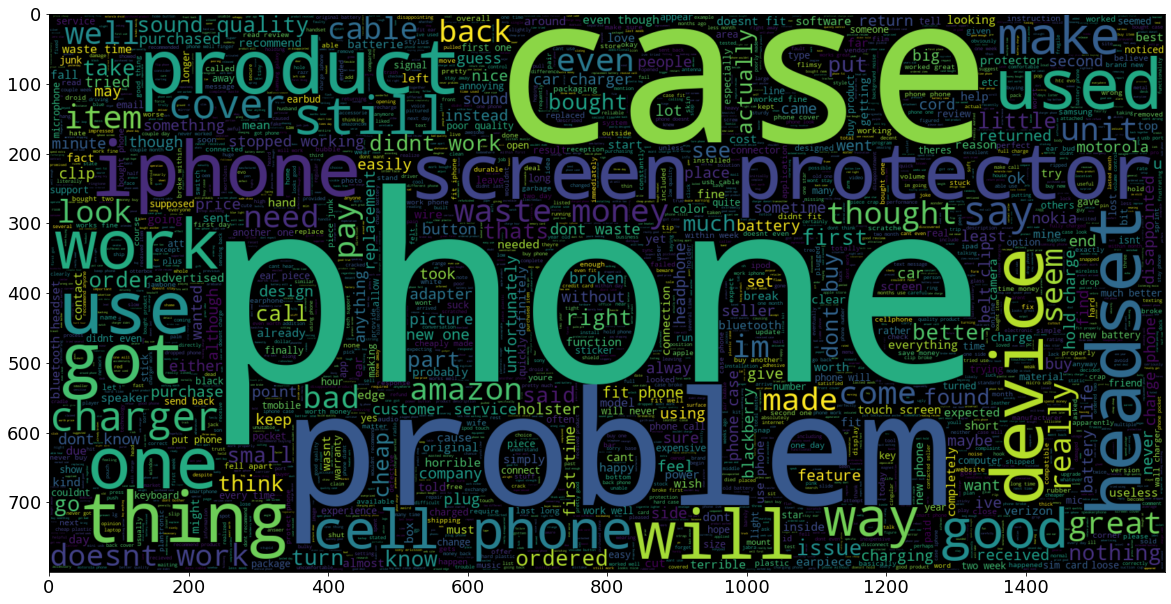

In [101]:
plt.figure(figsize = (20,20))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800).generate(" ".join(review_negative["combinedText"]))
plt.imshow(wc,interpolation = 'bilinear')

# Extract Features from reviews

In [33]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
data['sentiment']= label_encoder.fit_transform(data['sentiment']) 
  
data['sentiment'].unique() 

array([2, 0, 1])

In [34]:
data['sentiment'].value_counts() 

2    328922
0    122594
1     48484
Name: sentiment, dtype: int64

# Split into train and test set

In [35]:
x_train,x_test,y_train,y_test = train_test_split(data["combinedText"],data["sentiment"],test_size = 0.1, random_state = 1,stratify=data["sentiment"])

In [36]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((450000,), (50000,), (450000,), (50000,))

# Defining Lemmatizer parameters and Pos Tagging

In [37]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [38]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        pos = pos_tag([i.strip()])
        word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
        final_text.append(word)
    return " ".join(final_text)

In [39]:
lem_x_train = x_train.apply(lemmatize_words)

In [40]:
lem_x_train.shape

(450000,)

In [88]:
lem_x_train.to_csv('lem_x_train.csv',index=False)

In [37]:
lem = pd.read_csv(r"D:\lem_x_train.csv",index_col=False,usecols=["combinedText"])

In [38]:
lem_x_train=lem["combinedText"].apply(lambda x: np.str_(x))

In [39]:
lem_x_train

0         course dont use razor but charger work need ip...
1         take quite awhile get correctly think measurem...
2         get product estimate delivery timeexactly desc...
3         best thing around always lose earpiece dog wou...
4         simple install work great fairly rough use pas...
                                ...                        
449995    stuff best mount ever make small elegant discr...
449996    successfully charge ipod touch ipad wifi hotsp...
449997    face plate broke halfvery thin brittle plastic...
449998    cheap bulky charger not great design prong bro...
449999    order product mid january surprise mail appear...
Name: combinedText, Length: 450000, dtype: object

# Initialise TfidVectorizer

In [102]:
vectorizer = TfidfVectorizer()

tfv = TfidfVectorizer(strip_accents='unicode', 
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      stop_words = 'english')

Vectorise the words into numbers for training

In [103]:
tvf_x = tfv.fit_transform(lem_x_train)
tvf_y = y_train 
tvf_x_test=tfv.transform(x_test)

tvf_x.shape,tvf_y.shape,tvf_x_test.shape

((450000, 426374), (450000,), (50000, 426374))

# Model Testing

Four Models will be used to test to identify the accuracy of the model:
1) Logistic Regression
2) Support Vector Machine
3) Naive Bayes Bernoulli
4) Naive Bayes Multinomial

In [49]:
#creating the objects
logreg_cv = LogisticRegression(max_iter=5000)
svc_cv= LinearSVC()
mnb_cv= MultinomialNB()
nb_cv= BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'SVC',2:'Naive Bayes Bernoulli',3:'Naive Bayes Multinomial'}
cv_models=[logreg_cv,svc_cv,nb_cv,mnb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, tvf_x, tvf_y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8286155555555557
SVC Test Accuracy: 0.8301222222222222
Naive Bayes Bernoulli Test Accuracy: 0.7789355555555556
Naive Bayes Multinomial Test Accuracy: 0.7056844444444443


# From the result of the above model, we will tune the parameters for 2 models:

# 1) LinearSVC
# 2) Logistic Regression

In [104]:
svc = LinearSVC()
svc.fit(tvf_x, tvf_y)
svc_y_pred_model1 = svc.predict(tvf_x_test)
svc_score = accuracy_score(y_test,svc_y_pred_model1)
print("svc_tfidf_score :",svc_score)
print('Accuracy of Linear SVC classifier on test set: {:.2f}'.format(svc.score(tvf_x_test, y_test)))

svc_tfidf_score : 0.81486
Accuracy of Linear SVC classifier on test set: 0.81


In [105]:
#Classification report for tfidf features
svc_tfidf_report=classification_report(y_test,svc_y_pred_model1,target_names=['0','1','2'])
print(svc_tfidf_report)

              precision    recall  f1-score   support

           0       0.78      0.72      0.75     12259
           1       0.44      0.13      0.20      4849
           2       0.84      0.95      0.89     32892

    accuracy                           0.81     50000
   macro avg       0.69      0.60      0.61     50000
weighted avg       0.79      0.81      0.79     50000



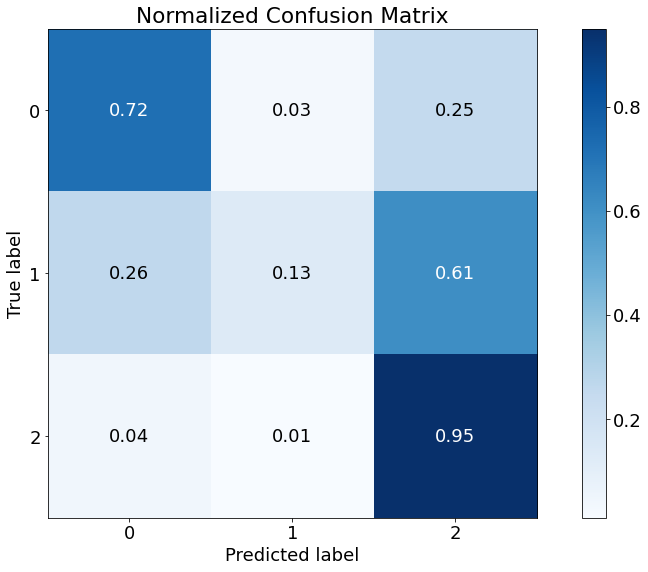

In [106]:
skplt.metrics.plot_confusion_matrix(y_test,svc_y_pred_model1, normalize=True)
plt.show()

## Parameter Tuning - LinearSVC
Grid Search will be used to find the best parameters for the identified model LinearSVC()

In [54]:
model = LinearSVC()
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1,cv=5, scoring='accuracy',error_score=0,verbose=3)
grid_result = grid_search.fit(tvf_x, tvf_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best: 0.829149 using {'C': 1.0}
0.783064 (0.001507) with: {'C': 100}
0.811536 (0.000504) with: {'C': 10}
0.829149 (0.000574) with: {'C': 1.0}
0.825771 (0.001077) with: {'C': 0.1}
0.809102 (0.001043) with: {'C': 0.01}


# Train the LinearSVC with optimum parameters identified by gridsearch

In [95]:
svc = LinearSVC(C = 1.0)
svc.fit(tvf_x, tvf_y)
svc_y_pred_model1 = svc.predict(tvf_x_test)
svc_score = accuracy_score(y_test,svc_y_pred_model1)
print("svc_tfidf_score :",svc_score)
print('Accuracy of Linear SVC classifier on test set: {:.2f}'.format(svc.score(tvf_x_test, y_test)))

svc_tfidf_score : 0.81486
Accuracy of Linear SVC classifier on test set: 0.81


In [96]:
#Classification report for tfidf features
svc_tfidf_report=classification_report(y_test,svc_y_pred_model1,target_names=['0','1','2'])
print(svc_tfidf_report)

              precision    recall  f1-score   support

           0       0.78      0.72      0.75     12259
           1       0.44      0.13      0.20      4849
           2       0.84      0.95      0.89     32892

    accuracy                           0.81     50000
   macro avg       0.69      0.60      0.61     50000
weighted avg       0.79      0.81      0.79     50000



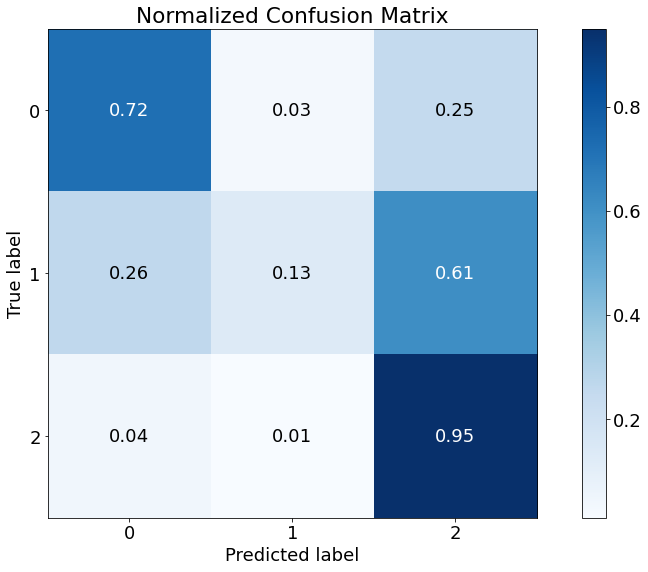

In [97]:
skplt.metrics.plot_confusion_matrix(y_test,svc_y_pred_model1, normalize=True)
plt.show()

# Searching Ideal parameters for TfidVectorizer and best parameters to improve accuracy

In [55]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LinearSVC())),
])
parameters = {
    'tfidf__max_df': (0.1,0.5),
    'tfidf__min_df': (0.1,1,5), 
    'tfidf__max_features':[500000,1000000],
    'tfidf__ngram_range': [(1,2),(1, 3)],
    'clf__estimator__C': (0.1,10)
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(lem_x_train, y_train)

print("Best parameters set:")
print (grid_search_tune.best_estimator_.steps)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


C:\Users\wayne\anaconda3\envs\tfgpu\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning:

One or more of the test scores are non-finite: [       nan        nan 0.84545333 0.84566    0.84622444 0.84606889
        nan        nan 0.84488222 0.84464222 0.84622444 0.84606889
 0.71857111 0.71856889 0.84902667 0.84915333 0.84956    0.84951556
 0.71856889 0.71857111 0.84851333 0.84804222 0.84956    0.84951556
        nan        nan 0.83482222 0.83817333 0.82566444 0.83409111
        nan        nan 0.84123556 0.84497556 0.82566444 0.83409111
 0.71855778 0.71855778 0.83700667 0.84027778 0.82827556 0.83619556
 0.71855556 0.71855556 0.84359111 0.84673556 0.82827556 0.83619556]



Best parameters set:
[('tfidf', TfidfVectorizer(max_df=0.5, max_features=500000, min_df=5, ngram_range=(1, 2))), ('clf', OneVsRestClassifier(estimator=LinearSVC(C=0.1)))]


Initialising TfidfVectorizer() with best parameter from search

In [88]:
vectorizer = TfidfVectorizer()

tuned_tfv = TfidfVectorizer(max_df =0.5,min_df=5,  max_features=500000,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1 , 2),
            stop_words = 'english')

Vectorise x_train and y_train with newly trained TfidfVectorizer()

In [89]:
svc_tuned_tvf_x = tuned_tfv.fit_transform(lem_x_train)
svc_tuned_tvf_y = y_train
svc_tuned_test_tv=tuned_tfv.transform(x_test)

svc_tuned_tvf_x.shape,svc_tuned_tvf_y.shape,svc_tuned_test_tv.shape

((450000, 387494), (450000,), (50000, 387494))

Testing model on test set

In [90]:
svc = LinearSVC(C=0.1)

svc.fit(svc_tuned_tvf_x, svc_tuned_tvf_y)
svc_y_pred_model2 = svc.predict(svc_tuned_test_tv)
svc_score = accuracy_score(y_test,svc_y_pred_model2)
print("svc_tfidf_score :",svc_score)
print('Accuracy of Linear SVC classifier on test set: {:.2f}'.format(svc.score(svc_tuned_test_tv,y_test )))

svc_tfidf_score : 0.82084
Accuracy of Linear SVC classifier on test set: 0.82


In [91]:
#Classification report for tfidf features
svc_tfidf_report=classification_report(y_test,svc_y_pred_model2,target_names=['0','1','2'])
print(svc_tfidf_report)

              precision    recall  f1-score   support

           0       0.80      0.72      0.76     12259
           1       0.55      0.09      0.16      4849
           2       0.83      0.97      0.89     32892

    accuracy                           0.82     50000
   macro avg       0.73      0.59      0.60     50000
weighted avg       0.80      0.82      0.79     50000



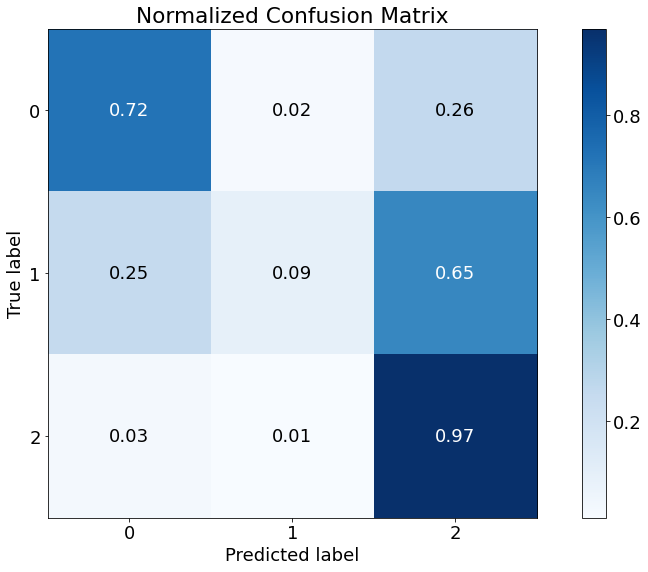

In [92]:
skplt.metrics.plot_confusion_matrix(y_test,svc_y_pred_model2, normalize=True)
plt.show()

# Plot ROC AOC Curve

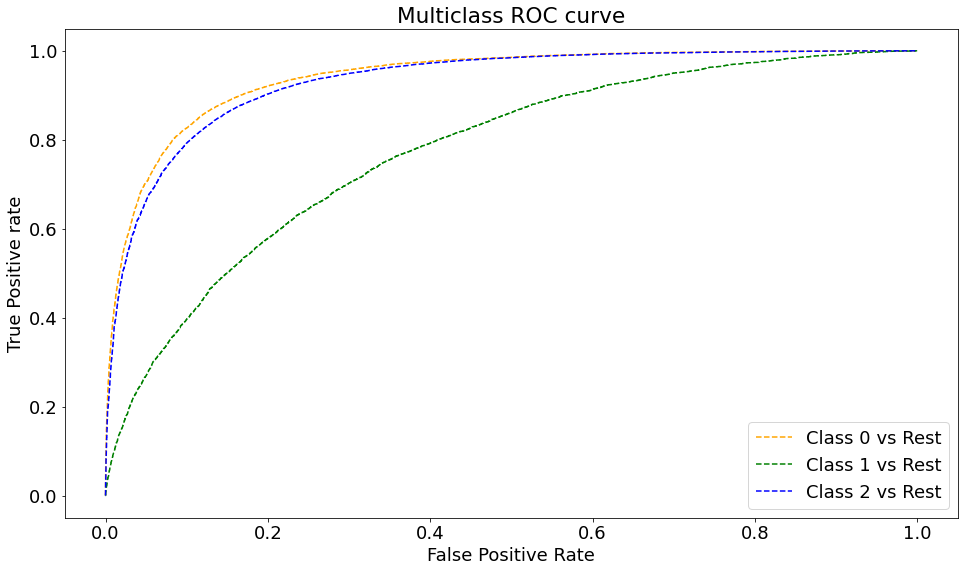

In [104]:
# fit model
clf = CalibratedClassifierCV(LinearSVC())
clf.fit(svc_tuned_tvf_x, svc_tuned_tvf_y)
pred = clf.predict(svc_tuned_test_tv)
pred_prob = clf.predict_proba(svc_tuned_test_tv)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

In [105]:
pred_prob1 = clf.predict_proba(svc_tuned_test_tv)
roc_auc = roc_auc_score(y_test, pred_prob1, multi_class='ovr')
print(roc_auc)

0.8818430907739524


# Smote to balance dataset

In [84]:
print(f'Original dataset shape : {Counter(svc_tuned_tvf_y)}')

smote = SMOTE(random_state=5,n_jobs=-1 )
svc_x_res, svc_y_res = smote.fit_resample(svc_tuned_tvf_x, svc_tuned_tvf_y)

print(f'Resampled dataset shape {Counter(svc_y_res)}')

Original dataset shape : Counter({2: 296030, 0: 110335, 1: 43635})
Resampled dataset shape Counter({2: 296030, 0: 296030, 1: 296030})


In [62]:
model = LinearSVC()
c_values = [1000,100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1,cv=5, scoring='accuracy',error_score=0,verbose=3)
grid_result = grid_search.fit(svc_x_res, svc_y_res)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best: 0.929753 using {'C': 10}
0.922310 (0.009748) with: {'C': 1000}
0.928800 (0.008851) with: {'C': 100}
0.929753 (0.009640) with: {'C': 10}
0.912286 (0.017182) with: {'C': 1.0}
0.849505 (0.029948) with: {'C': 0.1}
0.757215 (0.036568) with: {'C': 0.01}


Retrain model with resampled dataset

In [85]:
svc = LinearSVC(C=10)

svc.fit(svc_x_res, svc_y_res)
svc_y_pred_model3 = svc.predict(svc_tuned_test_tv)
svc_score = accuracy_score(y_test,svc_y_pred_model3)
print("lr_tfidf_score :",svc_score)
print('Accuracy of Linear SVC classifier on test set: {:.2f}'.format(svc.score(svc_tuned_test_tv, y_test)))

lr_tfidf_score : 0.79812
Accuracy of Linear SVC classifier on test set: 0.80


In [86]:
#Classification report for tfidf features
svc_tfidf_report=classification_report(y_test,svc_y_pred_model3,target_names=['0','1','2'])
print(svc_tfidf_report)

              precision    recall  f1-score   support

           0       0.78      0.72      0.75     12259
           1       0.31      0.26      0.28      4849
           2       0.86      0.91      0.89     32892

    accuracy                           0.80     50000
   macro avg       0.65      0.63      0.64     50000
weighted avg       0.79      0.80      0.79     50000



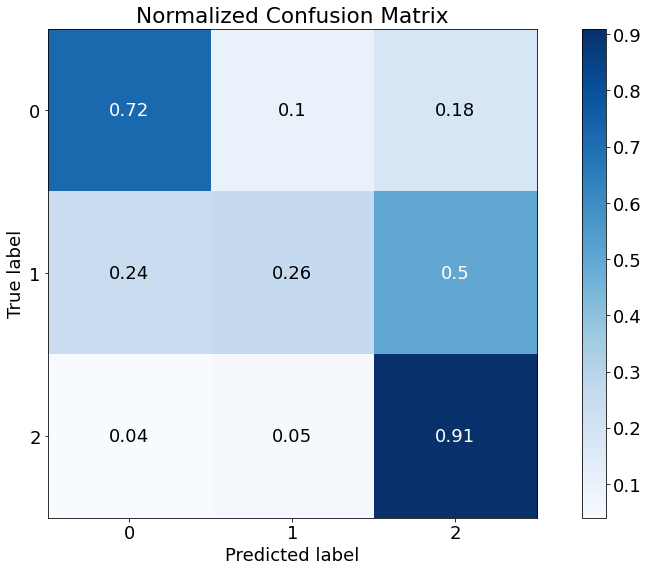

In [87]:
skplt.metrics.plot_confusion_matrix(y_test,svc_y_pred_model3, normalize=True)
plt.show()

# Borderline Smote

In [80]:
print(f'Original dataset shape : {Counter(svc_tuned_tvf_y)}')

smote = BorderlineSMOTE(random_state=5)
x_res, y_res = smote.fit_resample(svc_tuned_tvf_x, svc_tuned_tvf_y)


print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 296030, 0: 110335, 1: 43635})
Resampled dataset shape Counter({2: 296030, 0: 296030, 1: 296030})


Retrain model with resampled dataset

In [81]:
svc = LinearSVC()

svc.fit(x_res, y_res)
svc_y_pred_model4 = svc.predict(svc_tuned_test_tv)
svc_score = accuracy_score(y_test,svc_y_pred_model4)
print("lr_tfidf_score :",svc_score)
print('Accuracy of Linear SVC classifier on test set: {:.2f}'.format(svc.score(svc_tuned_test_tv, y_test)))

lr_tfidf_score : 0.80544
Accuracy of Linear SVC classifier on test set: 0.81


In [82]:
#Classification report for tfidf features
svc_tfidf_report=classification_report(y_test,svc_y_pred_model4,target_names=['0','1','2'])
print(svc_tfidf_report)

              precision    recall  f1-score   support

           0       0.77      0.74      0.75     12259
           1       0.33      0.28      0.30      4849
           2       0.88      0.91      0.89     32892

    accuracy                           0.81     50000
   macro avg       0.66      0.64      0.65     50000
weighted avg       0.80      0.81      0.80     50000



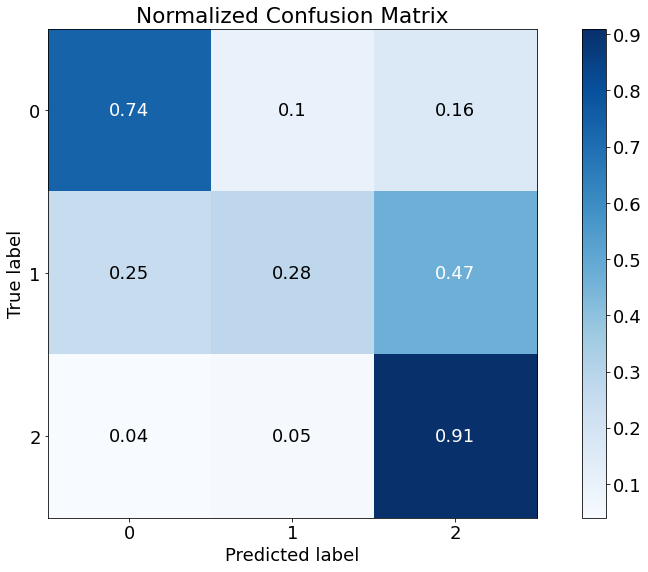

In [83]:
skplt.metrics.plot_confusion_matrix(y_test,svc_y_pred_model4, normalize=True)
plt.show()

# Over and Under Sampling Smote

In [76]:
print(f'Original dataset shape : {Counter(svc_tuned_tvf_y)}')

smote = SMOTE(random_state=5, sampling_strategy = {0:150000,1: 200000},n_jobs=-1 )
svc_x_res, svc_y_res = smote.fit_resample(svc_tuned_tvf_x, svc_tuned_tvf_y)

under = RandomUnderSampler(random_state=5,sampling_strategy={2: 250000})
svc_x_res, svc_y_res = under.fit_resample(svc_x_res, svc_y_res)

print(f'Resampled dataset shape {Counter(svc_y_res)}')

Original dataset shape : Counter({2: 296030, 0: 110335, 1: 43635})
Resampled dataset shape Counter({2: 250000, 1: 200000, 0: 150000})


In [77]:
svc = LinearSVC(C=10)

svc.fit(svc_x_res, svc_y_res)
svc_y_pred_model5 = svc.predict(svc_tuned_test_tv)
svc_score = accuracy_score(y_test,svc_y_pred_model5)
print("svc_tfidf_score :",svc_score)
print('Accuracy of Linear SVC classifier on test set: {:.2f}'.format(svc.score(svc_tuned_test_tv, y_test)))

svc_tfidf_score : 0.79582
Accuracy of Linear SVC classifier on test set: 0.80


In [78]:
#Classification report for tfidf features
svc_tfidf_report=classification_report(y_test,svc_y_pred_model5,target_names=['0','1','2'])
print(svc_tfidf_report)

              precision    recall  f1-score   support

           0       0.77      0.72      0.75     12259
           1       0.28      0.26      0.27      4849
           2       0.87      0.90      0.89     32892

    accuracy                           0.80     50000
   macro avg       0.64      0.63      0.63     50000
weighted avg       0.79      0.80      0.79     50000



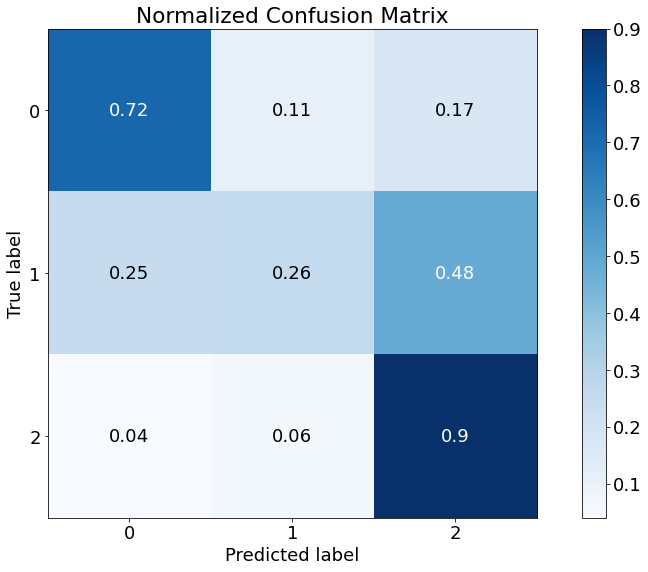

In [79]:
skplt.metrics.plot_confusion_matrix(y_test,svc_y_pred_model5, normalize=True)
plt.show()

# Logistic Regression

Run model with default value

In [69]:
lr = LogisticRegression(max_iter=5000)
lr.fit(tvf_x, tvf_y)
lr_y_pred_model1 = lr.predict(tvf_x_test)
lr_score = accuracy_score(y_test,lr_y_pred_model1)
print("lr_tfidf_score :",lr_score)
print('Accuracy of Linear SVC classifier on test set: {:.2f}'.format(lr.score(tvf_x_test, y_test)))

lr_tfidf_score : 0.81634
Accuracy of Linear SVC classifier on test set: 0.82


In [71]:
#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_y_pred_model1,target_names=['0','1','2'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

           0       0.79      0.71      0.75     12259
           1       0.49      0.12      0.20      4849
           2       0.83      0.96      0.89     32892

    accuracy                           0.82     50000
   macro avg       0.70      0.60      0.61     50000
weighted avg       0.79      0.82      0.79     50000



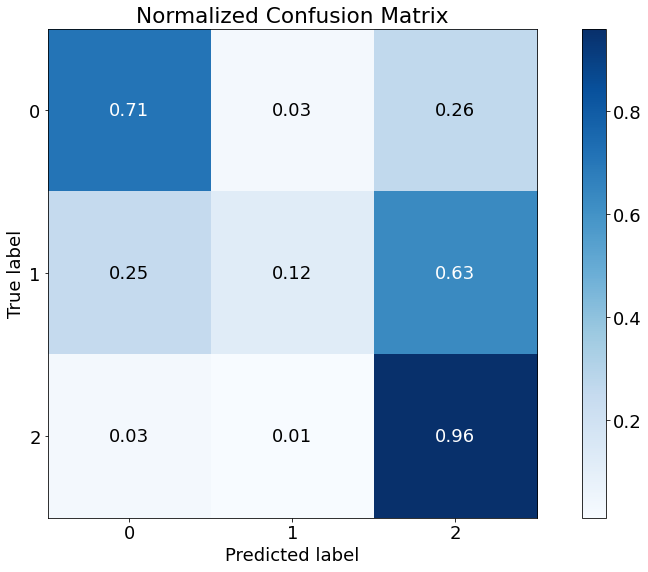

In [70]:
skplt.metrics.plot_confusion_matrix(y_test,lr_y_pred_model1, normalize=True)
plt.show()

Use gridsearch to find the best parameter for Logistic Regression

In [145]:
model = LogisticRegression(max_iter=5000)
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1,cv=5, scoring='accuracy',error_score=0,verbose=3)
grid_result = grid_search.fit(tvf_x, tvf_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best: 0.827596 using {'C': 1.0}
0.808398 (0.000619) with: {'C': 100}
0.826047 (0.000297) with: {'C': 10}
0.827596 (0.000701) with: {'C': 1.0}
0.815220 (0.001081) with: {'C': 0.1}
0.779467 (0.000786) with: {'C': 0.01}


In [107]:
lr = LogisticRegression(max_iter=5000,C=1)
lr.fit(tvf_x, tvf_y)
lr_y_pred_model1 = lr.predict(tvf_x_test)
lr_score = accuracy_score(y_test,lr_y_pred_model1)
print("lr_tfidf_score :",lr_score)
print('Accuracy of Linear SVC classifier on test set: {:.2f}'.format(lr.score(tvf_x_test, y_test)))

lr_tfidf_score : 0.81634
Accuracy of Linear SVC classifier on test set: 0.82


In [109]:
#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_y_pred_model1,target_names=['0','1','2'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

           0       0.79      0.71      0.75     12259
           1       0.49      0.12      0.20      4849
           2       0.83      0.96      0.89     32892

    accuracy                           0.82     50000
   macro avg       0.70      0.60      0.61     50000
weighted avg       0.79      0.82      0.79     50000



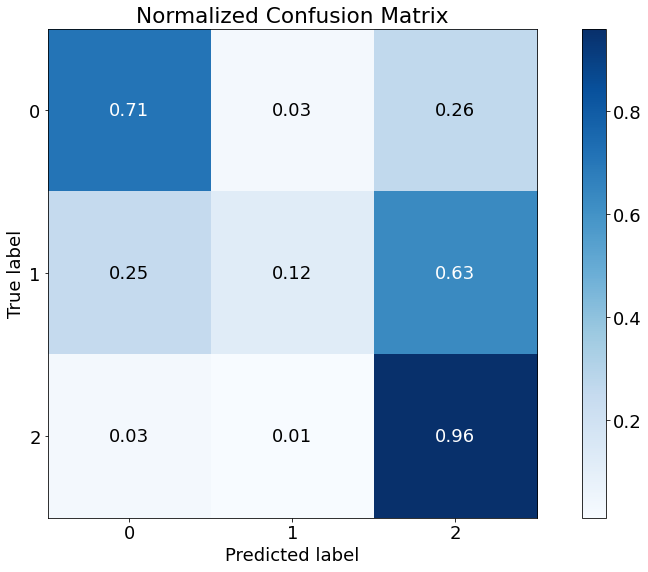

In [108]:
skplt.metrics.plot_confusion_matrix(y_test,lr_y_pred_model1, normalize=True)
plt.show()

# Gridsearch TfidfVectorizer

In [42]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LogisticRegression())),
])
parameters = {
    'tfidf__max_df': (0.1,0.5),
    'tfidf__min_df': (0.1,5), 
    'tfidf__max_features':[1000000],
    'tfidf__ngram_range': [(1,2),(1, 3)],
    'clf__estimator__C': (0.1,10)
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(lem_x_train, y_train)

print("Best parameters set:")
print (grid_search_tune.best_estimator_.steps)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


C:\Users\wayne\anaconda3\envs\tfgpu\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning:

One or more of the test scores are non-finite: [       nan        nan 0.80889556 0.8055     0.72019333 0.72019333
 0.81875111 0.81611556        nan        nan 0.84943778 0.85151556
 0.72055556 0.72055556 0.85216444 0.85348   ]

C:\Users\wayne\anaconda3\envs\tfgpu\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\wayne\anaconda3\envs\tfgpu\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITER

Best parameters set:
[('tfidf', TfidfVectorizer(max_df=0.5, max_features=1000000, min_df=5, ngram_range=(1, 3))), ('clf', OneVsRestClassifier(estimator=LogisticRegression(C=10)))]


C:\Users\wayne\anaconda3\envs\tfgpu\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Initialising TfidfVectorizer() with best parameter from search

In [43]:
vectorizer = TfidfVectorizer()

tuned_tfv = TfidfVectorizer(max_df =0.5, max_features=1000000,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1 , 3),
            stop_words = 'english')

Vectorise x_train and y_train with newly trained TfidfVectorizer()

In [44]:
lr_tuned_tvf_x = tuned_tfv.fit_transform(lem_x_train)
lr_tuned_tvf_y = y_train
lr_tuned_test_tv=tuned_tfv.transform(x_test)

lr_tuned_tvf_x.shape,lr_tuned_tvf_y.shape,lr_tuned_test_tv.shape

((450000, 1000000), (450000,), (50000, 1000000))

Testing model on test set

In [46]:
lr = LogisticRegression(C=10)

lr.fit(lr_tuned_tvf_x, lr_tuned_tvf_y)
lr_y_pred_model2 = lr.predict(lr_tuned_test_tv)
lr_score = accuracy_score(y_test,lr_y_pred_model2)
print("lr_tfidf_score :",svc_score)
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'.format(lr.score(lr_tuned_test_tv,y_test ))) 

lr_tfidf_score : 0.81386
Accuracy of Logistic Regression classifier on test set: 0.81


C:\Users\wayne\anaconda3\envs\tfgpu\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [66]:
#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_y_pred_model2,target_names=['0','1','2'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

           0       0.80      0.70      0.74     12259
           1       0.40      0.22      0.28      4849
           2       0.85      0.95      0.89     32892

    accuracy                           0.81     50000
   macro avg       0.68      0.62      0.64     50000
weighted avg       0.79      0.81      0.80     50000



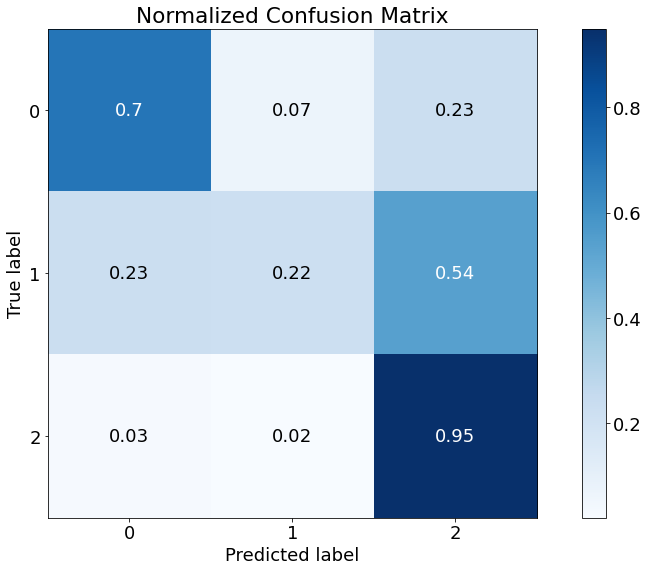

In [47]:
skplt.metrics.plot_confusion_matrix(y_test,lr_y_pred_model2, normalize=True)
plt.show()

C:\Users\wayne\anaconda3\envs\tfgpu\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\wayne\anaconda3\envs\tfgpu\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\wayne\anaco

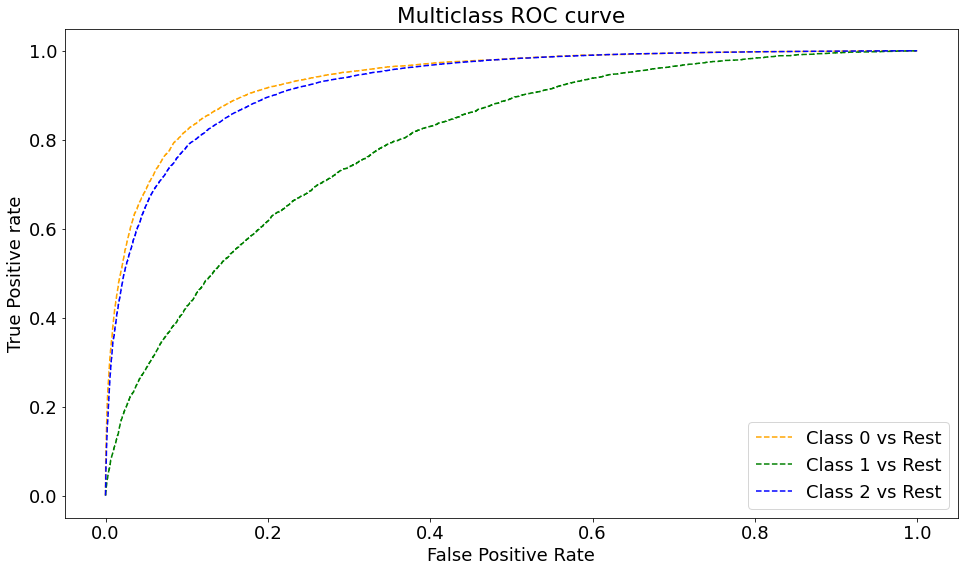

In [48]:
# fit model
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(lr_tuned_tvf_x, lr_tuned_tvf_y)
pred = clf.predict(lr_tuned_test_tv)
pred_prob = clf.predict_proba(lr_tuned_test_tv)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

In [50]:
pred_prob2 = clf.predict_proba(lr_tuned_test_tv)
roc_auc = roc_auc_score(y_test, pred_prob2, multi_class='ovr')
print(roc_auc)

0.886895453278063


In [51]:
print(f'Original dataset shape : {Counter(lr_tuned_tvf_y)}')

smote = SMOTE(random_state=5)
lr_x_res, lr_y_res = smote.fit_resample(lr_tuned_tvf_x, lr_tuned_tvf_y)


print(f'Resampled dataset shape {Counter(lr_y_res)}')

Original dataset shape : Counter({2: 296030, 0: 110335, 1: 43635})
Resampled dataset shape Counter({2: 296030, 0: 296030, 1: 296030})


In [52]:
lr_smote = LogisticRegression(C=10,max_iter=5000)

lr_smote.fit(lr_x_res, lr_y_res)
lr_y_pred_model3 = lr_smote.predict(lr_tuned_test_tv)
lr_smote_score = accuracy_score(y_test,lr_y_pred_model3)
print("lr_tfidf_score :",lr_smote_score)
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'.format(lr_smote.score(lr_tuned_test_tv, y_test)))

lr_tfidf_score : 0.80248
Accuracy of Logistic Regression classifier on test set: 0.80


In [65]:
#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_y_pred_model3,target_names=['0','1','2'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

           0       0.78      0.73      0.75     12259
           1       0.32      0.32      0.32      4849
           2       0.88      0.90      0.89     32892

    accuracy                           0.80     50000
   macro avg       0.66      0.65      0.65     50000
weighted avg       0.80      0.80      0.80     50000



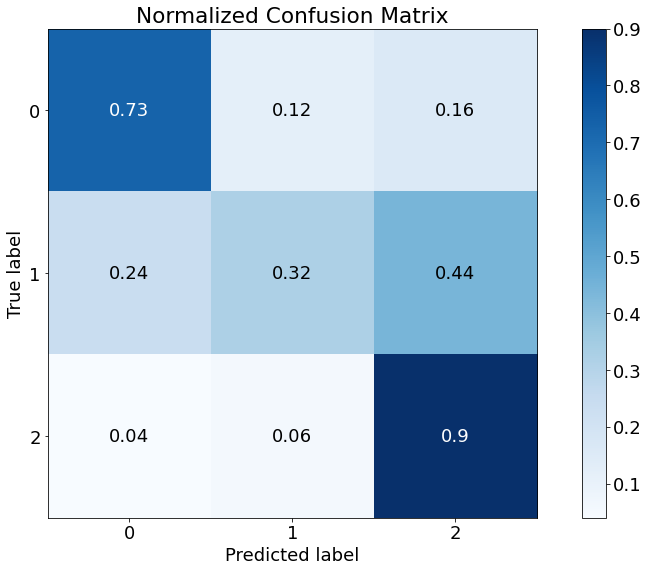

In [53]:
skplt.metrics.plot_confusion_matrix(y_test,lr_y_pred_model3, normalize=True)
plt.show()

# Borderline Smote

In [116]:
print(f'Original dataset shape : {Counter(lr_tuned_tvf_y)}')

smote = BorderlineSMOTE(random_state=5)
lr_x_res, lr_y_res = smote.fit_resample(lr_tuned_tvf_x, lr_tuned_tvf_y)


print(f'Resampled dataset shape {Counter(lr_y_res)}')

Original dataset shape : Counter({2: 296030, 0: 110335, 1: 43635})
Resampled dataset shape Counter({2: 296030, 0: 296030, 1: 296030})


In [117]:
lr_smote = LogisticRegression(C=10,max_iter=5000)

lr_smote.fit(lr_x_res, lr_y_res)
lr_y_pred_model3 = lr_smote.predict(lr_tuned_test_tv)
lr_smote_score = accuracy_score(y_test,lr_y_pred_model3)
print("lr_tfidf_score :",lr_smote_score)
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'.format(lr_smote.score(lr_tuned_test_tv, y_test)))

lr_tfidf_score : 0.80256
Accuracy of Logistic Regression classifier on test set: 0.80


In [118]:
#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_y_pred_model3,target_names=['0','1','2'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

           0       0.78      0.73      0.75     12259
           1       0.32      0.32      0.32      4849
           2       0.88      0.90      0.89     32892

    accuracy                           0.80     50000
   macro avg       0.66      0.65      0.65     50000
weighted avg       0.80      0.80      0.80     50000



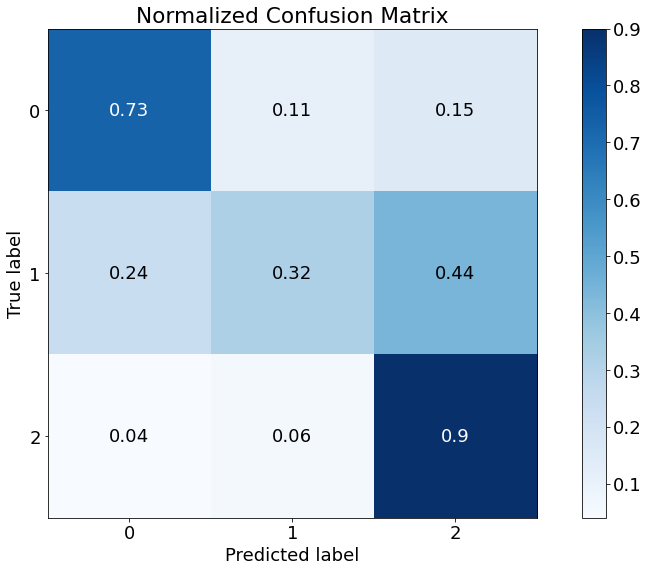

In [119]:
skplt.metrics.plot_confusion_matrix(y_test,lr_y_pred_model3, normalize=True)
plt.show()

# Over and Under Sampling Smote

In [112]:
print(f'Original dataset shape : {Counter(lr_tuned_tvf_y)}')

smote = SMOTE(random_state=5,sampling_strategy = {0:150000,1: 200000},n_jobs=-1)
lr_x_res, lr_y_res = smote.fit_resample(lr_tuned_tvf_x, lr_tuned_tvf_y)

under = RandomUnderSampler(random_state=5,sampling_strategy={2: 250000})
lr_x_res, lr_y_res = under.fit_resample(lr_x_res, lr_y_res)

print(f'Resampled dataset shape {Counter(lr_y_res)}')

Original dataset shape : Counter({2: 296030, 0: 110335, 1: 43635})
Resampled dataset shape Counter({2: 250000, 1: 200000, 0: 150000})


In [113]:
lr_smote = LogisticRegression(C=10,max_iter=5000)

lr_smote.fit(lr_x_res, lr_y_res)
lr_y_pred_model3 = lr_smote.predict(lr_tuned_test_tv)
lr_smote_score = accuracy_score(y_test,lr_y_pred_model3)
print("lr_tfidf_score :",lr_smote_score)
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'.format(lr_smote.score(lr_tuned_test_tv, y_test)))

lr_tfidf_score : 0.80332
Accuracy of Logistic Regression classifier on test set: 0.80


In [114]:
#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_y_pred_model3,target_names=['0','1','2'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

           0       0.79      0.72      0.75     12259
           1       0.32      0.33      0.33      4849
           2       0.88      0.91      0.89     32892

    accuracy                           0.80     50000
   macro avg       0.66      0.65      0.66     50000
weighted avg       0.80      0.80      0.80     50000



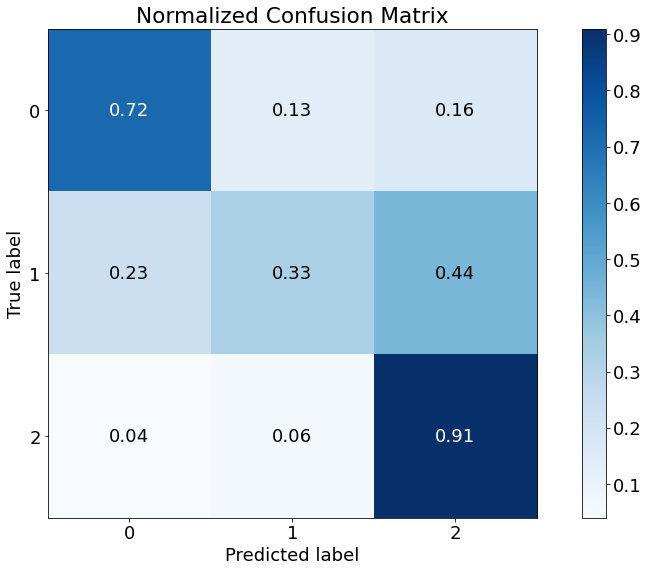

In [115]:
skplt.metrics.plot_confusion_matrix(y_test,lr_y_pred_model3, normalize=True)
plt.show()

In [121]:
# save the model to disk
model = lr_smote = LogisticRegression(C=10,max_iter=5000)
filename = 'best_performing_model.sav'
pickle.dump(model, open(filename, 'wb'))